In [4]:
#Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


In [10]:
# Define the stock ticker and date range
start = '2012-01-01'
end = '2022-12-21'
stock = 'GOOG'

In [11]:
# Download stock data using yfinance with error handling
try:
    data = yf.download(stock, start=start, end=end)
    if data.empty:
        raise ValueError(f"No data found for ticker {stock} between {start} and {end}.")
except Exception as e:
    print(f"Error downloading data: {e}")
    exit()

[*********************100%***********************]  1 of 1 completed


In [12]:
# Reset index to move the date from index to a column
data.reset_index(inplace=True)

In [13]:
# Validate essential columns are present
required_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
if not all(column in data.columns for column in required_columns):
    missing = list(set(required_columns) - set(data.columns))
    raise ValueError(f"Missing columns in data: {missing}")

In [14]:
# Display first few rows of the data
print("Downloaded Data:")
print(data.head())

Downloaded Data:
        Date       Open       High        Low      Close  Adj Close     Volume
0 2012-01-03  16.262545  16.641375  16.248346  16.573130  16.532528  147611217
1 2012-01-04  16.563665  16.693678  16.453827  16.644611  16.603836  114989399
2 2012-01-05  16.491436  16.537264  16.344486  16.413727  16.373516  131808205
3 2012-01-06  16.417213  16.438385  16.184088  16.189817  16.150156  108119746
4 2012-01-09  16.102144  16.114599  15.472754  15.503389  15.465409  233776981



# -------------------- Moving Averages Calculation -------------------- #

In [15]:
# Calculate 100-day moving average
ma_100_days = data['Close'].rolling(window=100).mean()

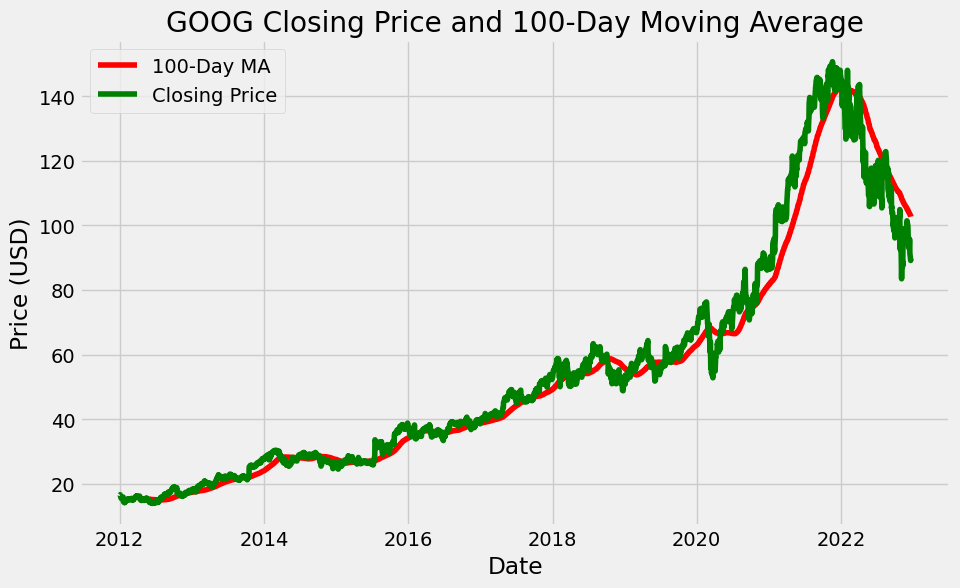

In [16]:
# Plot 100-day moving average and closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], ma_100_days, 'r', label='100-Day MA')
plt.plot(data['Date'], data['Close'], 'g', label='Closing Price')
plt.title(f'{stock} Closing Price and 100-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [17]:
# Calculate 200-day moving average
ma_200_days = data['Close'].rolling(window=200).mean()

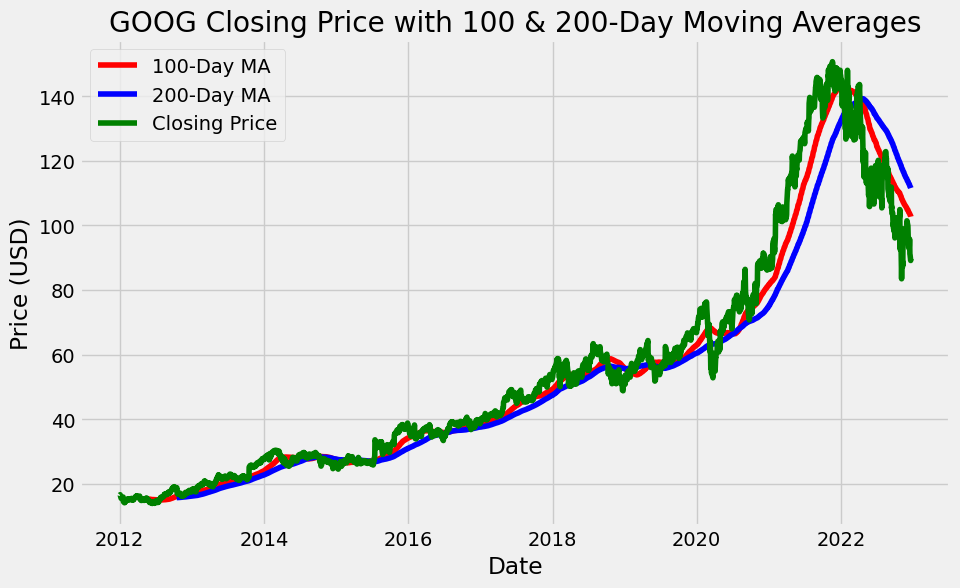

In [18]:
# Plot 100-day MA, 200-day MA, and closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], ma_100_days, 'r', label='100-Day MA')
plt.plot(data['Date'], ma_200_days, 'b', label='200-Day MA')
plt.plot(data['Date'], data['Close'], 'g', label='Closing Price')
plt.title(f'{stock} Closing Price with 100 & 200-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [19]:
# Remove rows with NaN values resulting from moving averages
data.dropna(inplace=True)

# -------------------- Data Splitting -------------------- #

In [20]:
# Define training and testing split (80% train, 20% test)
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size

In [21]:
# Ensure there is enough data for splitting
if train_size < 100:
    raise ValueError("Training data is too small. Consider adjusting the split ratio or the window size.")

data_train = data[['Close']].iloc[:train_size].copy()
data_test = data[['Close']].iloc[train_size:].copy()

print(f"Training data points: {data_train.shape[0]}")
print(f"Testing data points: {data_test.shape[0]}")

Training data points: 2208
Testing data points: 553


# -------------------- Data Scaling -------------------- #

In [22]:
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [23]:
# Fit scaler on training data and transform
data_train_scale = scaler.fit_transform(data_train)

In [24]:
# Check for scaling errors
if np.isnan(data_train_scale).any():
    raise ValueError("Scaling resulted in NaN values in training data.")

# -------------------- Creating Training Sequences -------------------- #

In [25]:
# Define window size
window_size = 100

x_train = []
y_train = []

In [26]:
# Create sequences of 100 data points for training
for i in range(window_size, len(data_train_scale)):
    x_train.append(data_train_scale[i - window_size:i, 0])
    y_train.append(data_train_scale[i, 0])

In [27]:
# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [28]:
# Reshape x_train to be [samples, time_steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [29]:
# Validate shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (2108, 100, 1)
y_train shape: (2108,)


# -------------------- Building the LSTM Model -------------------- #

In [35]:
# Initialize the Sequential model
model = Sequential()

In [36]:
# Add first LSTM layer with Dropout
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

In [37]:
# Add second LSTM layer with Dropout
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

In [38]:
# Add third LSTM layer with Dropout
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

In [39]:
# Add fourth LSTM layer with Dropout
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

In [40]:
# Add the output layer
model.add(Dense(units=1))

In [41]:

# Compile the model with Adam optimizer and Mean Squared Error loss
model.compile(optimizer='adam', loss='mean_squared_error')

In [42]:
# Display model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

# -------------------- Training the Model -------------------- #

In [43]:
# Train the model with validation split and early stopping
from keras.callbacks import EarlyStopping

In [44]:
# Define early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [45]:
# Fit the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1, callbacks=[early_stop])

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 317ms/step - loss: 0.0724
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - loss: 0.0075
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - loss: 0.0059
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - loss: 0.0066
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - loss: 0.0054
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - loss: 0.0055
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 283ms/step - loss: 0.0050
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - loss: 0.0052
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 277ms/step - loss: 0.0048
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - loss: 0.0041
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - loss: 0.0035
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - loss: 0.0039
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - loss: 0.0037
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 325ms/step - loss: 0.0039
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 

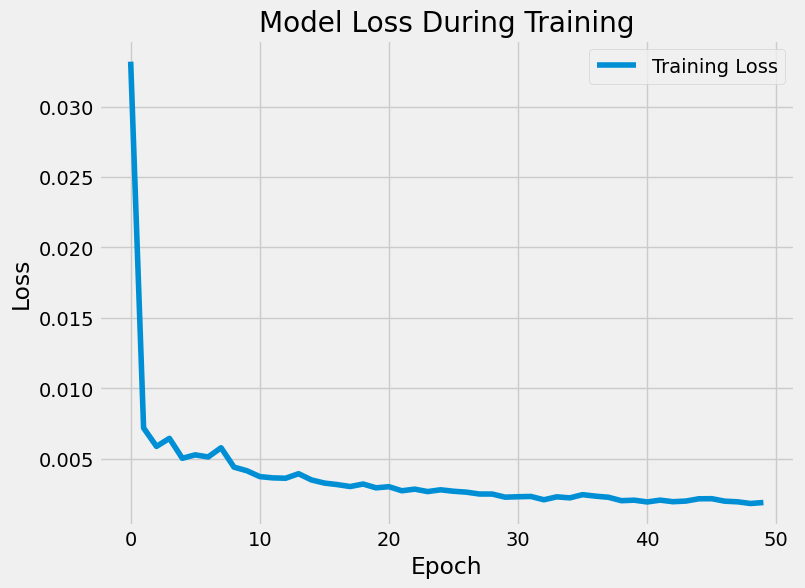

In [46]:
# Plot training loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# -------------------- Preparing Test Data -------------------- #

In [47]:
# Get the last 100 days from training data to create the initial test sequence
past_100_days = data_train.tail(window_size).copy()

In [48]:
# Combine past 100 days with test data for scaling
data_test_combined = pd.concat([past_100_days, data_test], ignore_index=True)

In [49]:
# Scale the combined test data
data_test_scale = scaler.transform(data_test_combined)

In [50]:
# Check for scaling errors
if np.isnan(data_test_scale).any():
    raise ValueError("Scaling resulted in NaN values in test data.")

In [51]:
# Create test sequences
x_test = []
y_test = []

for i in range(window_size, len(data_test_scale)):
    x_test.append(data_test_scale[i - window_size:i, 0])
    y_test.append(data_test_scale[i, 0])

In [52]:
# Convert lists to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

In [53]:
# Reshape x_test to be [samples, time_steps, features]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [54]:
# Validate shapes
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_test shape: (553, 100, 1)
y_test shape: (553,)


# -------------------- Making Predictions -------------------- #

In [55]:
# Predict using the trained model
y_pred_scaled = model.predict(x_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step


In [56]:
# Inverse transform the scaled predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# -------------------- Evaluating the Model -------------------- #

In [67]:
# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
print(f"Mean Squared Error on Test Data: {mse}")
print(f"Mean Absolute Error on Test Data: {mae}")

Mean Squared Error on Test Data: 675.5369596960991
Mean Absolute Error on Test Data: 22.90333310173821


In [70]:
# Plot the predictions vs actual prices
plt.figure(figsize=(14, 7))


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

In [73]:
import matplotlib.pyplot as plt

# Assuming 'Date' is the correct column name and exists in data_test
# If the column name is different, update it accordingly
# Example: If the column is named 'date', use data_test['date'] instead

# Check if 'Date' column exists in data_test
if 'Date' in data_test.columns:
    plt.plot(data_test['Date'].iloc[window_size:].values, y_pred, 'r', label='Predicted Price')
else:
    print("Error: 'Date' column not found in data_test DataFrame. Please check your data.")
    # If 'Date' column is not found, you might need to:
    # 1. Load the data again, making sure the 'Date' column is included.
    # 2. Check for any data manipulation steps that might have removed or renamed the column.
    # 3. Adjust the column name in the code if it's different (e.g., 'date', 'DATE').

Error: 'Date' column not found in data_test DataFrame. Please check your data.


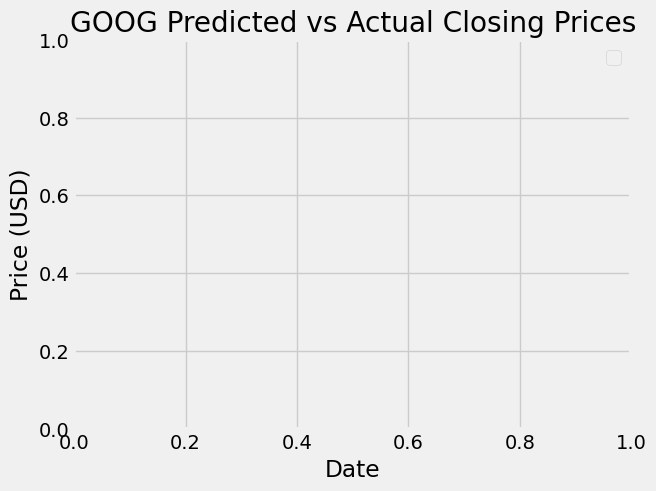

In [77]:
plt.title(f'{stock} Predicted vs Actual Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# -------------------- Saving the Model -------------------- #

In [78]:
# Define the model save path
model_filename = 'Stock_Predictions_Model.keras'

In [80]:
import os  # Import the os module

# Define the model save path
model_filename = 'Stock_Predictions_Model.keras'

# Check if the directory exists, if not, create it
save_dir = os.path.dirname(model_filename)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [81]:
# Check if the directory exists, if not, create it
save_dir = os.path.dirname(model_filename)
if save_dir and not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [82]:
# Save the trained model
model.save(model_filename)
print(f"Model saved to {model_filename}")

Model saved to Stock_Predictions_Model.keras
